## Logistic Regression 

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, hamming_loss
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Load the pre-split data
train_df = pd.read_csv('csv/pokemon_train.csv')
test_df = pd.read_csv('csv/pokemon_test.csv')

# Prepare features and targets
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']
X_train = train_df[features]
X_test = test_df[features]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Prepare targets for primary type
y_train_primary_type = train_df['Primary_Type']
y_test_primary_type = test_df['Primary_Type']

# Prepare targets for both types
y_train_both_types = train_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_test_both_types = test_df[['Primary_Type', 'Secondary_Type']].values.tolist()

# Remove NaN values for secondary types
y_train_both_types = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_train_both_types]
y_test_both_types = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_test_both_types]

# Binarize the labels for multi-label classification
mlb = MultiLabelBinarizer()
y_train_both_types_bin = mlb.fit_transform(y_train_both_types)
y_test_both_types_bin = mlb.transform(y_test_both_types)

# Logistic Regression for Primary Type prediction
lr_model_primary = LogisticRegression(multi_class='ovr', max_iter=1000)
lr_model_primary.fit(X_train_scaled, y_train_primary_type)
lr_predictions_primary = lr_model_primary.predict(X_test_scaled)

lr_accuracy_primary = accuracy_score(y_test_primary_type, lr_predictions_primary)

print("Logistic Regression Results (Primary Type):")
print(f"Accuracy for Primary Type prediction: {lr_accuracy_primary}")
print("\nClassification Report for Primary Type prediction:")
print(classification_report(y_test_primary_type, lr_predictions_primary))

# Logistic Regression for Both Types prediction
lr_model_both = OneVsRestClassifier(LogisticRegression(max_iter=1000))
lr_model_both.fit(X_train_scaled, y_train_both_types_bin)
lr_predictions_both = lr_model_both.predict(X_test_scaled)

lr_accuracy_both = accuracy_score(y_test_both_types_bin, lr_predictions_both)
lr_hamming_loss = hamming_loss(y_test_both_types_bin, lr_predictions_both)

print("\nLogistic Regression Results (Both Types):")
print(f"Accuracy for Both Types prediction: {lr_accuracy_both}")
print(f"Hamming Loss for Both Types prediction: {lr_hamming_loss}")
print("\nClassification Report for Both Types prediction:")
print(classification_report(y_test_both_types_bin, lr_predictions_both, target_names=mlb.classes_))

Logistic Regression Results (Primary Type):
Accuracy for Primary Type prediction: 0.22926829268292684

Classification Report for Primary Type prediction:
              precision    recall  f1-score   support

         Bug       0.17      0.18      0.17        17
        Dark       0.00      0.00      0.00         9
      Dragon       0.25      0.14      0.18         7
    Electric       0.33      0.17      0.22        12
       Fairy       0.00      0.00      0.00         6
    Fighting       0.50      0.38      0.43         8
        Fire       0.20      0.23      0.21        13
      Flying       0.00      0.00      0.00         2
       Ghost       0.00      0.00      0.00         7
       Grass       0.27      0.30      0.29        20
      Ground       0.00      0.00      0.00         8
         Ice       0.00      0.00      0.00         6
      Normal       0.34      0.67      0.45        24
      Poison       0.00      0.00      0.00         8
     Psychic       0.08      0.08  

/Users/marvinchen/Desktop/IW/cos-independent-work/cos397/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/marvinchen/Desktop/IW/cos-independent-work/cos397/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marvinchen/Desktop/IW/cos-independent-work/cos397/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

In [4]:
### ATTEMPT TO PREDICT BOTH TYPES (OR SINGLE TYPE)

# Function to get top N predicted types
def get_top_n_types(probabilities, n=2):
    return [mlb.classes_[idx] for idx in np.argsort(probabilities)[::-1][:n]]

# Get probabilities for type prediction
y_pred_type_proba = lr_type.predict_proba(X_test_scaled)

# Print example predictions
for i in range(5):  # Print first 5 examples
    true_types = mlb.inverse_transform(y_test_type)[i]
    pred_types = get_top_n_types(y_pred_type_proba[i])
    print(f"\nExample {i+1}:")
    print(f"True Types: {true_types}")
    print(f"Predicted Types: {pred_types}")
    print(f"True Generation: {y_test_gen.iloc[i]}")
    print(f"Predicted Generation: {y_pred_gen[i]}")


Example 1:
True Types: ('Dragon', 'Fighting')
Predicted Types: ['Water', 'Grass']
True Generation: 7.0
Predicted Generation: 1.0

Example 2:
True Types: ('Dark',)
Predicted Types: ['Fighting', 'Dark']
True Generation: 3.0
Predicted Generation: 5.0

Example 3:
True Types: ('Normal', 'Psychic')
Predicted Types: ['Psychic', 'Fairy']
True Generation: 5.0
Predicted Generation: 4.0

Example 4:
True Types: ('Grass',)
Predicted Types: ['Water', 'Psychic']
True Generation: 2.0
Predicted Generation: 9.0

Example 5:
True Types: ('Bug', 'Ground')
Predicted Types: ['Bug', 'Water']
True Generation: 3.0
Predicted Generation: 1.0


In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, hamming_loss
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV

# Load the pre-split data
train_df = pd.read_csv('csv/pokemon_train.csv')
test_df = pd.read_csv('csv/pokemon_test.csv')

# Prepare features and targets
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']
X_train = train_df[features]
X_test = test_df[features]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Prepare targets for primary type
y_train_primary_type = train_df['Primary_Type']
y_test_primary_type = test_df['Primary_Type']

# Prepare targets for both types
y_train_both_types = train_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_test_both_types = test_df[['Primary_Type', 'Secondary_Type']].values.tolist()

# Remove NaN values for secondary types
y_train_both_types = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_train_both_types]
y_test_both_types = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_test_both_types]

# Binarize the labels for multi-label classification
mlb = MultiLabelBinarizer()
y_train_both_types_bin = mlb.fit_transform(y_train_both_types)
y_test_both_types_bin = mlb.transform(y_test_both_types)

# Define parameter grid for GridSearchCV
param_grid = {
    'estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'estimator__penalty': ['l1', 'l2'],
    'estimator__solver': ['liblinear', 'saga']
}

# Logistic Regression for Primary Type prediction with GridSearchCV
grid_search_primary = GridSearchCV(OneVsRestClassifier(LogisticRegression(max_iter=10000)), param_grid, cv=5)
grid_search_primary.fit(X_train_scaled, y_train_primary_type)

print("Best parameters for Primary Type prediction:")
print(grid_search_primary.best_params_)

lr_model_primary = grid_search_primary.best_estimator_
lr_predictions_primary = lr_model_primary.predict(X_test_scaled)

lr_accuracy_primary = accuracy_score(y_test_primary_type, lr_predictions_primary)

print("\nLogistic Regression Results (Primary Type):")
print(f"Accuracy for Primary Type prediction: {lr_accuracy_primary}")
print("\nClassification Report for Primary Type prediction:")
print(classification_report(y_test_primary_type, lr_predictions_primary))

# Logistic Regression for Both Types prediction with GridSearchCV
grid_search_both = GridSearchCV(OneVsRestClassifier(LogisticRegression(max_iter=10000)), param_grid, cv=5)
grid_search_both.fit(X_train_scaled, y_train_both_types_bin)

print("\nBest parameters for Both Types prediction:")
print(grid_search_both.best_params_)

lr_model_both = grid_search_both.best_estimator_
lr_predictions_both = lr_model_both.predict(X_test_scaled)

lr_accuracy_both = accuracy_score(y_test_both_types_bin, lr_predictions_both)
lr_hamming_loss = hamming_loss(y_test_both_types_bin, lr_predictions_both)

print("\nLogistic Regression Results (Both Types):")
print(f"Accuracy for Both Types prediction: {lr_accuracy_both}")
print(f"Hamming Loss for Both Types prediction: {lr_hamming_loss}")
print("\nClassification Report for Both Types prediction:")
print(classification_report(y_test_both_types_bin, lr_predictions_both, target_names=mlb.classes_))

Best parameters for Primary Type prediction:
{'estimator__C': 100, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}

Logistic Regression Results (Primary Type):
Accuracy for Primary Type prediction: 0.22926829268292684

Classification Report for Primary Type prediction:
              precision    recall  f1-score   support

         Bug       0.16      0.18      0.17        17
        Dark       0.00      0.00      0.00         9
      Dragon       0.33      0.14      0.20         7
    Electric       0.33      0.17      0.22        12
       Fairy       0.00      0.00      0.00         6
    Fighting       0.43      0.38      0.40         8
        Fire       0.20      0.23      0.21        13
      Flying       0.00      0.00      0.00         2
       Ghost       0.00      0.00      0.00         7
       Grass       0.29      0.30      0.29        20
      Ground       0.00      0.00      0.00         8
         Ice       0.00      0.00      0.00         6
      Normal 

/Users/marvinchen/Desktop/IW/cos-independent-work/cos397/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marvinchen/Desktop/IW/cos-independent-work/cos397/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marvinchen/Desktop/IW/cos-independent-work/cos397/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control


Best parameters for Both Types prediction:
{'estimator__C': 1, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}

Logistic Regression Results (Both Types):
Accuracy for Both Types prediction: 0.0
Hamming Loss for Both Types prediction: 0.08373983739837398

Classification Report for Both Types prediction:
              precision    recall  f1-score   support

         Bug       0.00      0.00      0.00        18
        Dark       0.00      0.00      0.00        14
      Dragon       0.00      0.00      0.00        16
    Electric       0.00      0.00      0.00        13
       Fairy       0.00      0.00      0.00        11
    Fighting       0.00      0.00      0.00        18
        Fire       0.00      0.00      0.00        17
      Flying       0.00      0.00      0.00        18
       Ghost       0.00      0.00      0.00        11
       Grass       0.00      0.00      0.00        25
      Ground       0.00      0.00      0.00        18
         Ice       0.00      0.0

/Users/marvinchen/Desktop/IW/cos-independent-work/cos397/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marvinchen/Desktop/IW/cos-independent-work/cos397/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


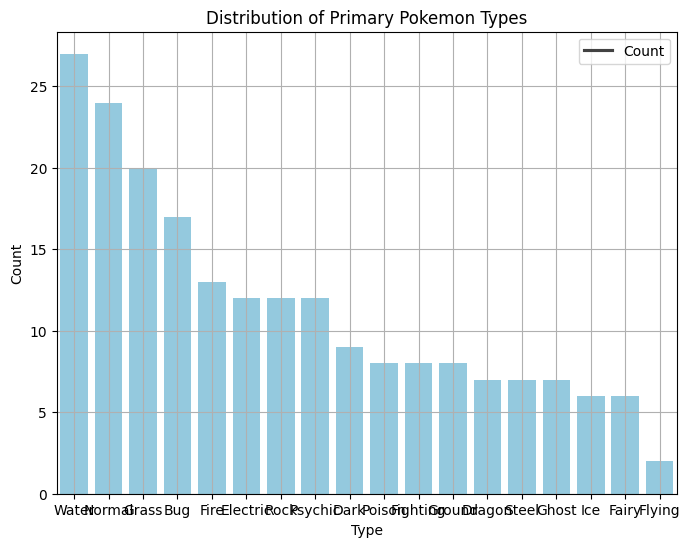

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of occurrences of each primary type in the test set
primary_type_counts = y_test_primary_type.value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=primary_type_counts.index, y=primary_type_counts.values, color="skyblue")
plt.title('Distribution of Primary Pokemon Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.legend(['Count'])
plt.grid(True)
plt.show()


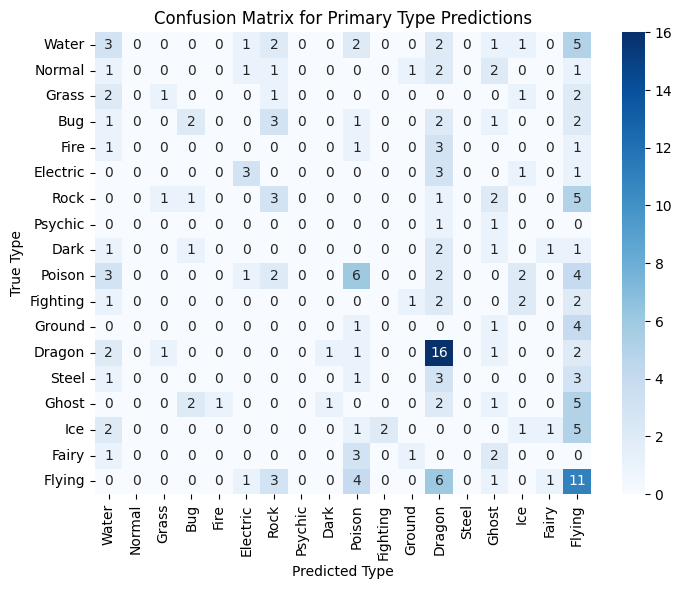

In [11]:
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_primary_type, lr_predictions_primary)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=primary_type_counts.index, yticklabels=primary_type_counts.index)
plt.title('Confusion Matrix for Primary Type Predictions')
plt.xlabel('Predicted Type')
plt.ylabel('True Type')
plt.show()

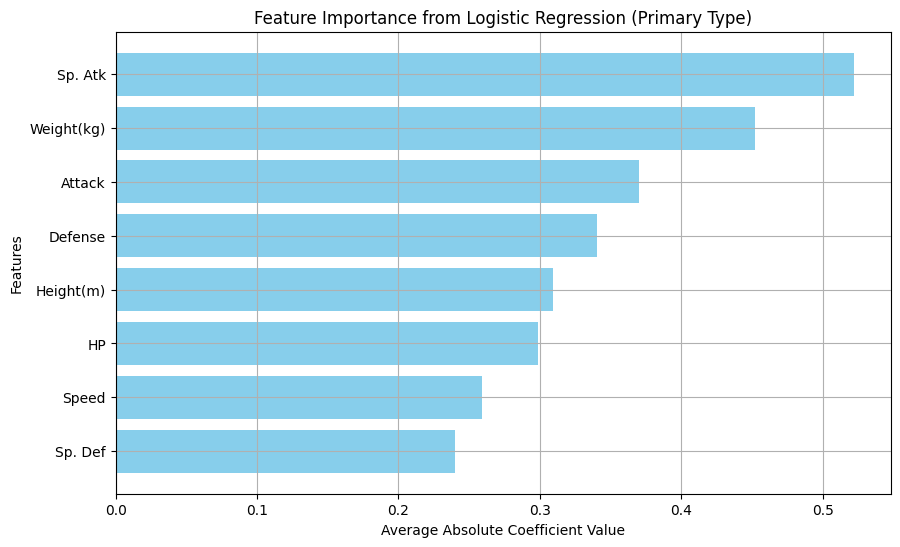

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming lr_model_primary is your trained OneVsRestClassifier for primary type prediction
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']

# Initialize an array to store the average absolute coefficients
avg_coef = np.zeros(len(features))

# Iterate through all estimators (one for each class)
for estimator in lr_model_primary.estimators_:
    avg_coef += np.abs(estimator.coef_[0])

# Calculate the average
avg_coef /= len(lr_model_primary.estimators_)

# Sort features by importance (average absolute value of coefficients)
sorted_idx = np.argsort(avg_coef)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx], avg_coef[sorted_idx], color='skyblue')
plt.xlabel('Average Absolute Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importance from Logistic Regression (Primary Type)')
plt.grid(True)
plt.show()

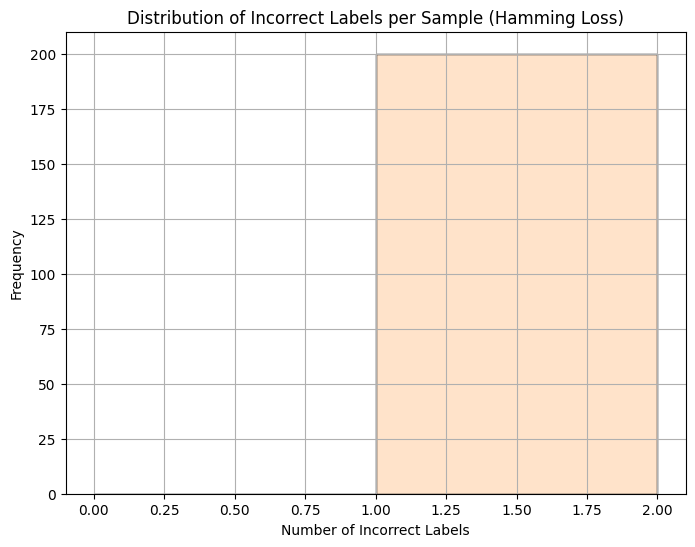

In [13]:
# Calculate Hamming loss per sample (number of incorrect labels per sample)
incorrect_labels_per_sample = np.sum(np.abs(y_test_both_types_bin - lr_predictions_both), axis=1)

# Plot Hamming loss distribution
plt.figure(figsize=(8, 6))
sns.histplot(incorrect_labels_per_sample, bins=np.arange(0, 3), kde=False, color='peachpuff')
plt.title('Distribution of Incorrect Labels per Sample (Hamming Loss)')
plt.xlabel('Number of Incorrect Labels')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

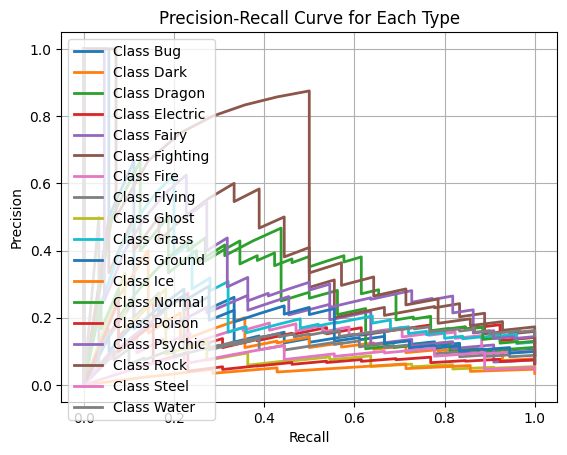

In [14]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall curve for each label (type)
for i in range(len(mlb.classes_)):
    precision, recall, _ = precision_recall_curve(y_test_both_types_bin[:, i], lr_model_both.predict_proba(X_test_scaled)[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {mlb.classes_[i]}')

# Plot settings
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Type")
plt.legend(loc="best")
plt.grid(True)
plt.show()

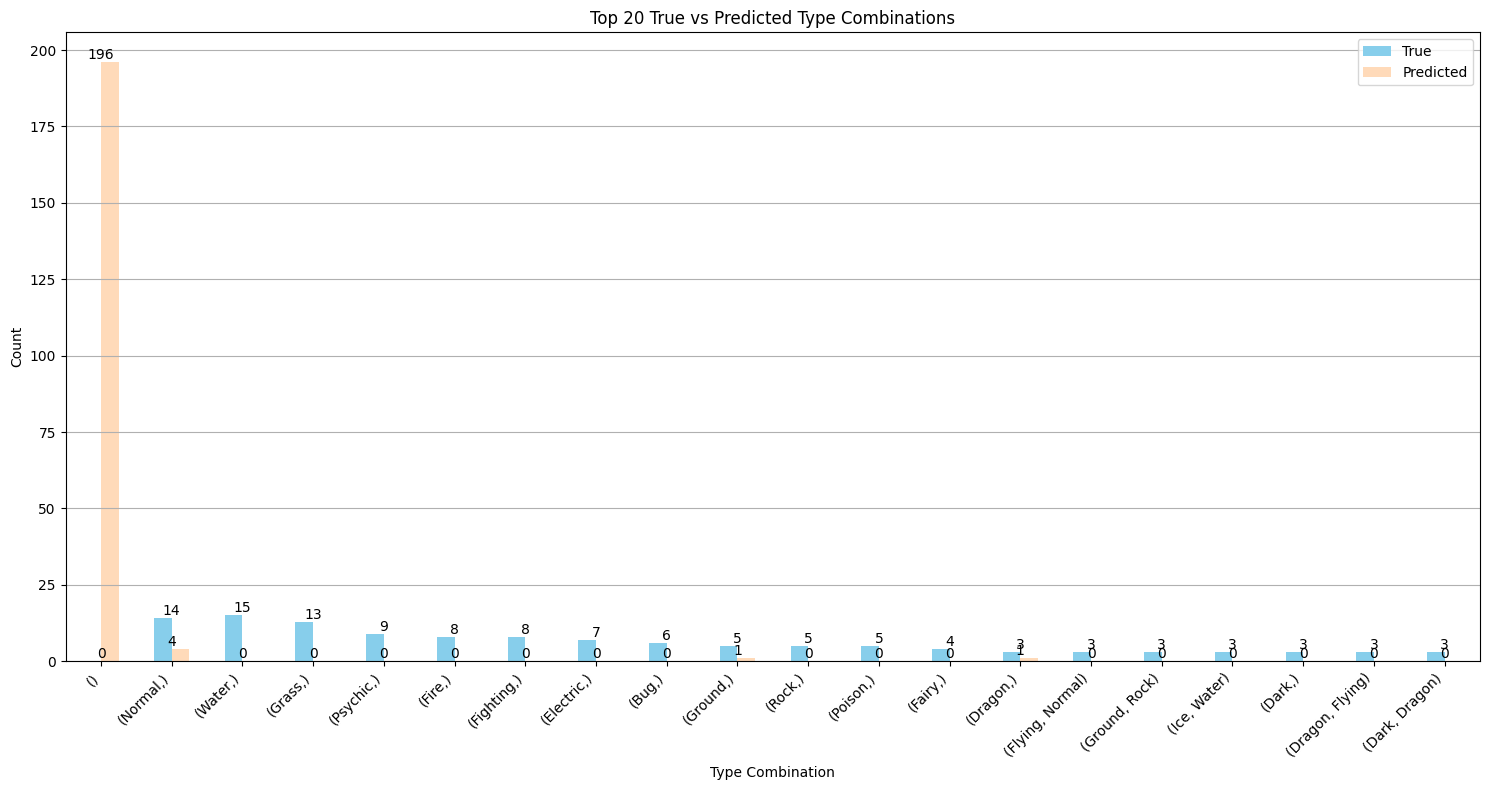

In [18]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Count true type combinations
true_combinations = Counter([tuple(sorted(filter(None, t))) for t in y_test_both_types])

# For predicted combinations, we need to convert the binary predictions back to labels
predicted_types = mlb.inverse_transform(lr_predictions_both)
predicted_combinations = Counter([tuple(sorted(filter(None, t))) for t in predicted_types])

# Create a set of all unique combinations
all_combinations = set(true_combinations.keys()) | set(predicted_combinations.keys())

# Create a DataFrame with all combinations and fill in the counts
combinations_df = pd.DataFrame({
    'True': [true_combinations.get(comb, 0) for comb in all_combinations],
    'Predicted': [predicted_combinations.get(comb, 0) for comb in all_combinations]
}, index=list(all_combinations))

# Sort the DataFrame by the sum of True and Predicted counts
combinations_df['Total'] = combinations_df['True'] + combinations_df['Predicted']
combinations_df = combinations_df.sort_values('Total', ascending=False).drop('Total', axis=1)

# Select top N combinations for better visibility
top_n = 20  # Adjust this value to show more or fewer combinations
combinations_df = combinations_df.head(top_n)

# Plot bar chart of type combinations
ax = combinations_df.plot(kind='bar', figsize=(15, 8), color=['skyblue', 'peachpuff'])
plt.title(f'Top {top_n} True vs Predicted Type Combinations')
plt.xlabel('Type Combination')
plt.ylabel('Count')
plt.legend(['True', 'Predicted'])
plt.grid(True, axis='y')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Add value labels on the bars
for i, (index, row) in enumerate(combinations_df.iterrows()):
    ax.text(i, row['True'], str(int(row['True'])), ha='center', va='bottom')
    ax.text(i, row['Predicted'], str(int(row['Predicted'])), ha='center', va='bottom')

plt.show()